#  Sentiment Analysis from Amazon Book Reviews

# Section I: Problem Statement

With the large-scale data availability and increasing popularity of online service platforms, more and more users have begun reading reviews of listed items before deciding to perform a purchase transaction. To help user to make decision, we use machine learning techniques to perform sentiment analysis or intent mining to analyze the product reviews. In this work, we used two classical machine learning algorithm: Multinomial Naive Bayes classifier and XGBoost classifier, two deep learning algorithms:  fine-tuned BERT classifier and zero-shot inference by utlizing the pre-trained LLM to classify the intent of reviews to positive or negative. These models are applied to the open public amazon book review data to perform intent mining . From our extensive experiments, we observed the deep learning BERT model and zero-shot classifier outperform the other two baseline models. The F1-score of using a deep learning model can be boosted by around $25\%$. 

# Section II - Environment Setup

## 1. SetUp

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA A10G


## 2. Dataset

### 2.1. Download Dataset 
- Kaggle:https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

### 2.2. Load raw data from own hard-disk and sample 

In [ ]:
ratings = pd.read_csv('../input/amazon-books-reviews/Books_rating.csv')
books = pd.read_csv('../input/amazon-books-reviews/books_data.csv')
print(ratings.shape)
print(books.shape)

In [ ]:
data = pd.merge(ratings,books, on = 'Title')
data.shape

In [ ]:
data = data[['Title','review/score','review/text','authors','categories','ratingsCount']]

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
data.dropna(inplace = True)

In [ ]:
bi_data = data[data['review/score']!=3]

In [ ]:
s_bi_data = bi_data.sample(10000)

In [ ]:
s_bi_data.to_csv('amz_data/bi_sentiment_10000.csv')

### 2.3. Load data

In [3]:
 # Load dataset 
data = pd.read_csv('amz_data/bi_sentiment_10000.csv')
data.sample(5)

,Unnamed: 0,Title,review/score,review/text,authors,categories,ratingsCount
9667,2618344,Cat's cradle (A Dell book),5.0,Having never read any Vonnegut before (but hea...,['Kurt Vonnegut'],['Fiction'],157.0
6010,1725074,Stranger in a Strange Land : ( Science Fiction...,5.0,This book is not for everyone.If you have iron...,['Robert A. Heinlein'],['Fiction'],116.0
2051,2169968,Charlie All Night (Harlequin Temptation),5.0,Crusie...please...don't...stop...writing....pa...,['Jennifer Crusie'],['Fiction'],14.0
9842,2072886,Blaze and the forest fire,5.0,The Billy and Blaze books were a staple of my ...,['C.W. Anderson'],['Juvenile Fiction'],1.0
467,1601571,"The Lion, the Witch and the Wardrobe (Chronicl...",5.0,That is all I can say about thiis book. It is ...,['C.S. Lewis'],['Fiction'],394.0


In [4]:
data['review/score'].value_counts()

5.0    6492
4.0    2223
1.0     729
2.0     556
Name: review/score, dtype: int64

- convert to binary label 

In [5]:
##### amz , Binary Label 
data['label']= data['review/score'].apply(lambda x: '0' if x >= 4.0 else '1')
data.head()

,Unnamed: 0,Title,review/score,review/text,authors,categories,ratingsCount,label
0,1842978,Fix-It and Forget-It Diabetic Cookbook: Slow-C...,5.0,I bougjht it hoping to fix something for my fr...,"['Phyllis Pellman Good', 'American Diabetes As...",['Cooking'],1.0,0
1,724501,Harry Potter and The Sorcerer's Stone,1.0,Harry Potter and the Sorcerer's stone was the ...,['J. K. Rowling'],['Juvenile Fiction'],1.0,1
2,2983315,"Encyclopedia Brown, Boy Detective",5.0,"I'm almost 20 years old now, but I can still r...",['Donald J. Sobol'],['Juvenile Fiction'],3.0,0
3,1898553,Drop City,4.0,"I've have never read anything by TC Boyle, and...",['T.C. Boyle'],['Fiction'],49.0,0
4,2675553,WATERSHIP DOWN - AVON #19810,5.0,This is the BEST book I have ever read. I got ...,['Richard Adams'],['Fiction'],243.0,0


- Randomly split the data into two sets: 90:10 for train vs. validation . We perform hyperparameter tuning using cross-validation on the train data and use the validation set to compare models.

In [6]:
### amz 
from sklearn.model_selection import train_test_split

X = data['review/text'].values
y = data.label.values

X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=2020)

In [7]:
###get validation set dataframe to save for prompt using 
# Get the indices of the validation set in the original data
val_indices = np.where(np.isin(X, X_val))[0]
# Retrieve validation set from the original dataframe
validation_df = data.iloc[val_indices]
validation_df.shape

(1011, 8)

In [8]:
#save the validation set 
validation_df.to_csv("/data/sentiment/prompt_val.csv")

### 2.3. Load Test Data


In [42]:
# # Load test data
test_data = pd.read_csv('amz_data/sentiment_test_2000.csv')

In [44]:
test_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'review/score', 'review/text',
       'authors', 'categories', 'ratingsCount'],
      dtype='object')

In [62]:
X_test = test_data['review/text']

In [63]:
test_data['label']= test_data['review/score'].apply(lambda x: '0' if x >= 4.0 else '1')

In [64]:
y_test = test_data['label']

# Section III - Pre-processing /Feature Engineering

## 1. Data Preparation

### 1.1. Preprocessing

In [9]:
!pip install nltk

In [47]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. TF-IDF Vectorizer

In [58]:
# https://stackoverflow.com/questions/47778403/computing-tf-idf-on-the-whole-dataset-or-only-on-training-data

from sklearn.feature_extraction.text import TfidfVectorizer

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

#  TF-IDF vectors 
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [48]:
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

In [59]:
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

In [14]:
X_train_tfidf.shape

(9000, 1135112)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

<!-- # 1. Logistic regression  -->

## 1. Multinomial Naive Bayes classifier
https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

### 2.1. Hyperparameter Tuning , AUC , Confusion Matrix 

cross-validation and AUC and precision_recall AUC score to tune hyperparameters. The function `get_auc_CV` will return the average AUC score from cross-validation.

In [17]:

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [18]:
def get_precision_recall_CV(model, X, y):
    """
    Return the average AUC score from cross-validation using StratifiedKFold.
    """
    # Set up Stratified K-Fold cross-validator
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # Compute AUC scores using cross-validation
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)

    return np.mean(auc_scores)

In [ ]:
def calculate_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]
    precision = []
    recall = []
    f1_score = []
    
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = sum(conf_matrix[:, i]) - tp  # sum of column i excluding true positives
        fn = sum(conf_matrix[i, :]) - tp  # sum of row i excluding true positives
        
        precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        precision.append(precision_class)
        recall.append(recall_class)
        
        # Calculate F1 score using precision and recall
        f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0.0
        f1_score.append(f1_class)
    
    return precision, recall, f1_score

In [19]:
def get_auc_CV(model, X, y):
    """
    Return the average AUC score from cross-validation using StratifiedKFold.
    """
    # Set up Stratified K-Fold cross-validator
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # Compute AUC scores using cross-validation
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)

    return np.mean(auc_scores)

# Generate a range of alpha values
alphas = np.arange(1, 10, 0.1)

# Compute AUC scores for different alpha values using cross-validation
res = pd.Series([get_auc_CV(MultinomialNB(alpha=a), X_train_tfidf, y_train) for a in alphas], index=alphas)

# Find the best alpha value based on maximum AUC score
best_alpha = res.idxmax()

# Round the best alpha value to two decimal places
best_alpha_rounded = np.round(best_alpha, 2)

# Print the best alpha value
print('Best alpha:', best_alpha_rounded)

Best alpha: 1.0


### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [34]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true, model_name):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    #print("y_true.shape=",y_true.shape, "preds.shape=",preds.shape)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('ROC -'+ model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [22]:
y_val = [int(label) for label in y_val]
# # probs[0:10]

AUC: 0.6185
Accuracy: 86.40%


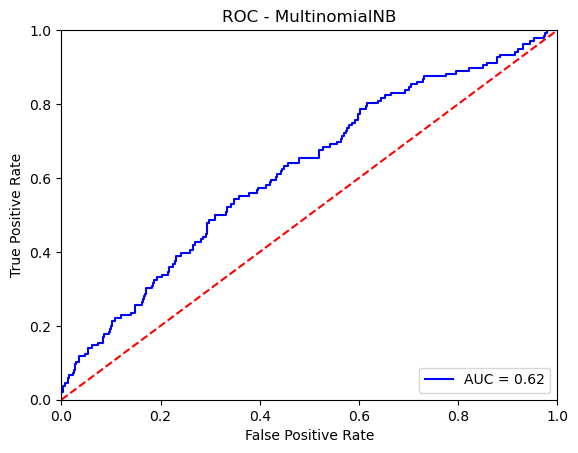

In [23]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [24]:
from sklearn.metrics import auc

In [40]:
y_val[y_val==0]

0

In [27]:
yy_val = np.array(y_val) 
len(yy_val[yy_val==0])

864

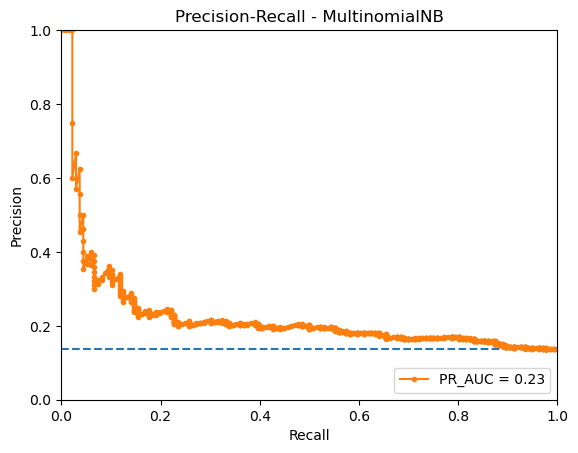

In [28]:
# precision, recall, thresholds = precision_recall_curve(y_val, probs)
preds = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_val, preds)
plt.title('Precision-Recall - MultinomialNB')
# calculate precision-recall AUC
pr_auc = auc(lr_recall, lr_precision)
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
no_skill = len(yy_val[yy_val==1]) / len(yy_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--') #, label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label = 'PR_AUC = %0.2f' % pr_auc) 
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

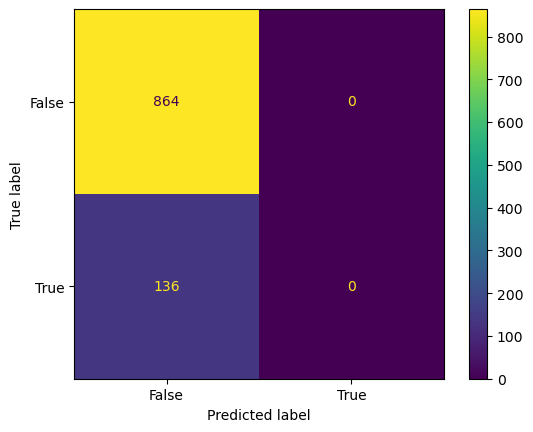

In [29]:
threshold = 0.5
y_probs= (probs[:,1] >= threshold).astype(int)
confusion_matrix = metrics.confusion_matrix(yy_val, y_probs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [32]:
precision, recall, f1_score = calculate_metrics(confusion_matrix)
print(precision, recall,f1_score )
print("Class\tPrecision\tRecall\tf1_score")
for i in range(len(precision)):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1_score[i]:.4f}")

[0.864, 0.0] [1.0, 0.0] [0.9270386266094421, 0.0]
Class	Precision	Recall	f1_score
0	0.8640		1.0000		0.9270
1	0.0000		0.0000		0.0000


# Model II - Fine-tuning BERT

## 1. Install the Hugging Face Library

In [35]:
!pip install transformers #==2.8.0

## 2. Tokenization and Input Formatting

In [36]:
def text_preprocessing(text):
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [37]:
# Print sentence 0
print('Raw: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Raw:  I bougjht it hoping to fix something for my friends who are diabetics but haven't made anything yet. I looked at the recipes and they look good and pretty easy.
Processed:  I bougjht it hoping to fix something for my friends who are diabetics but haven't made anything yet. I looked at the recipes and they look good and pretty easy.


### 2.1. BERT Tokenizer


The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.



In [38]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [39]:
#amz 
all_reviews = data['review/text']

# Encode 
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_reviews]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


Max length:  3616


In [40]:
# `MAX_LEN`
MAX_LEN = 64#64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Raw: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Raw:  I bougjht it hoping to fix something for my friends who are diabetics but haven't made anything yet. I looked at the recipes and they look good and pretty easy.
Token IDs:  [101, 1045, 8945, 15916, 3501, 11039, 2009, 5327, 2000, 8081, 2242, 2005, 2026, 2814, 2040, 2024, 22939, 20915, 6558, 2021, 4033, 1005, 1056, 2081, 2505, 2664, 1012, 1045, 2246, 2012, 1996, 19328, 1998, 2027, 2298, 2204, 1998, 3492, 3733, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [103]:
y_train= y_train.astype(int)
y_val = np.array(y_val).astype(int)

In [42]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train BERT classifier

### 3.1. Create BertClassifier

In [43]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):

        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

        # load BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # create an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
   
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 123 ms, sys: 12.4 ms, total: 136 ms
Wall time: 392 ms


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [44]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):

    bert_classifier = BertClassifier(freeze_bert=False)

    bert_classifier.to(device)


    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8   
                      )

    total_steps = len(train_dataloader) * epochs


    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.

In [45]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training done!")


def evaluate(model, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        #  logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        #  loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # predictions
        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

### 3.4. Evaluation on Validation Set

In [47]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9372
Accuracy: 91.80%


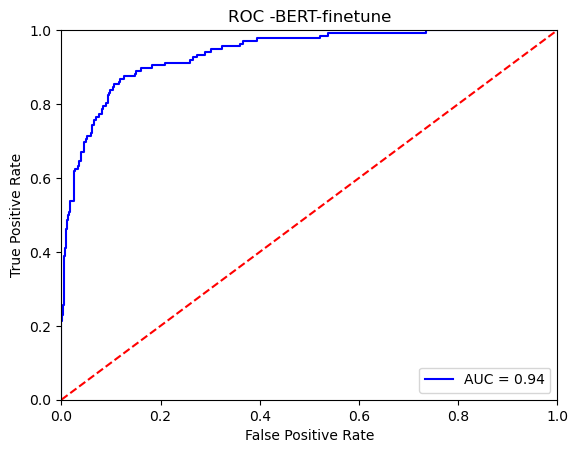

In [56]:
# Compute  probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate
evaluate_roc(probs, y_val, "BERT-finetune")

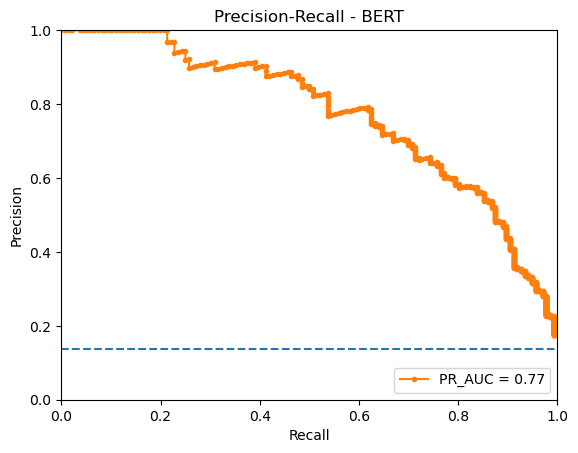

In [52]:
# precision, recall, thresholds = precision_recall_curve(y_val, probs)
preds = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_val, preds)
plt.title('Precision-Recall - BERT')
# calculate precision-recall AUC
pr_auc = auc(lr_recall, lr_precision)
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
no_skill = len(yy_val[yy_val==1]) / len(yy_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--') #, label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label = 'PR_AUC = %0.2f' % pr_auc) 
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [68]:
len(y_val[y_val==1])

136

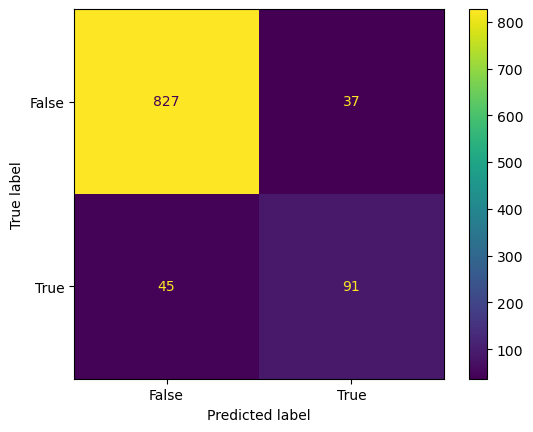

In [57]:
from sklearn import metrics

threshold = 0.5
y_probs= (probs[:,1] >= threshold).astype(int)
confusion_matrix = metrics.confusion_matrix(y_val, y_probs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [50]:
# Compute precision and recall for each class
precision, recall, f1_score = calculate_metrics(confusion_matrix)
print(precision, recall,f1_score )

[0.948394495412844, 0.7109375] [0.9571759259259259, 0.6691176470588235] [0.9527649769585254, 0.6893939393939394]


In [51]:
print("Class\tPrecision\tRecall\tf1_score")
for i in range(len(precision)):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1_score[i]:.4f}")

Class	Precision	Recall	f1_score
0	0.9484		0.9572		0.9528
1	0.7109		0.6691		0.6894


##  xgboost classifier

In [100]:
!pip install xgboost

In [104]:
# y_train

In [114]:
from xgboost import XGBClassifier

# Create an instance of the XGBClassifier for multi-classifier 
#model = XGBClassifier(objective='multi:softprob')
# for binary classifier
xgb_model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
# xgb_model.fit(X_train_tfidf, y_train)

In [121]:
xgb_grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [117]:
param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [ 0.01, 0.001],
    'n_estimators': [100, 200]
}

In [119]:
# Pass the instance to GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)

# Now fit the model
xgb_grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,


In [108]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [122]:
### Binary -tf-idf
xgb_accuracy = xgb_grid_search.score(X_val_tfidf, y_val)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Accuracy: 86.80%


AUC: 0.8848
Accuracy: 90.40%


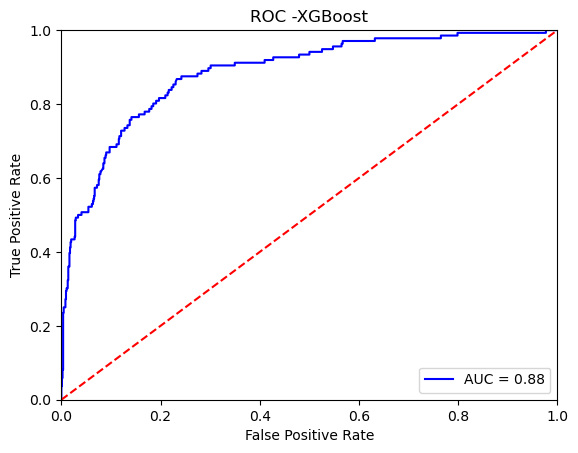

In [124]:
xgb_probs = model.predict_proba(X_val_tfidf)
# Evaluate the classifier
evaluate_roc(xgb_probs, y_val, "XGBoost")

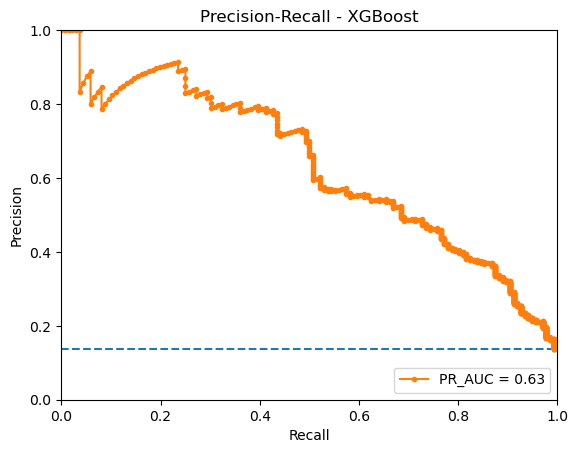

In [125]:
# precision, recall, thresholds = precision_recall_curve(y_val, probs)
preds = xgb_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_val, preds)
plt.title('Precision-Recall - XGBoost')
pr_auc = auc(lr_recall, lr_precision)
no_skill = len(yy_val[yy_val==1]) / len(yy_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--') #, label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.',label = 'PR_AUC = %0.2f' % pr_auc) 
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

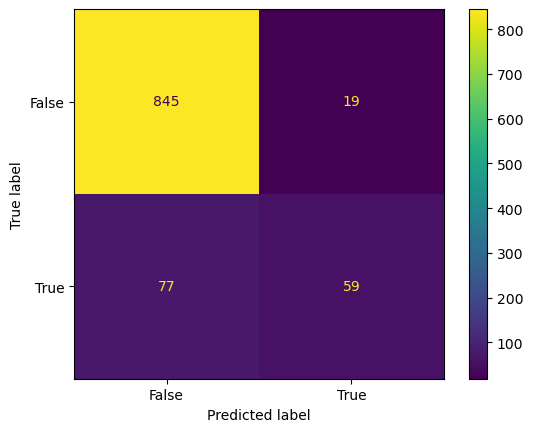

In [126]:
threshold = 0.5
xgb_probs= (xgb_probs[:,1] >= threshold).astype(int)
confusion_matrix = metrics.confusion_matrix(y_val, xgb_probs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [90]:
precision, recall, f1_score = calculate_metrics(confusion_matrix)
print(precision, recall,f1_score )

[0.9164859002169198, 0.7564102564102564] [0.9780092592592593, 0.4338235294117647] [0.9462486002239643, 0.5514018691588785]


In [91]:
print("Class\tPrecision\tRecall\tf1_score")
for i in range(len(precision)):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1_score[i]:.4f}")

Class	Precision	Recall	f1_score
0	0.9165		0.9780		0.9462
1	0.7564		0.4338		0.5514


In [104]:
### PRompt 
prompt_df = pd.read_csv("./prompt_out.csv") 
prompt_df.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Title,review/score,review/text,authors,categories,ratingsCount,label,prompt_out
0,0,1,724501,Harry Potter and The Sorcerer's Stone,1.0,Harry Potter and the Sorcerer's stone was the ...,['J. K. Rowling'],['Juvenile Fiction'],1.0,1,1
1,1,10,876524,The Conservative Revolution: The Movement That...,1.0,"America is being remade, but not by these guys...",['Lee Edwards'],['History'],1.0,1,1


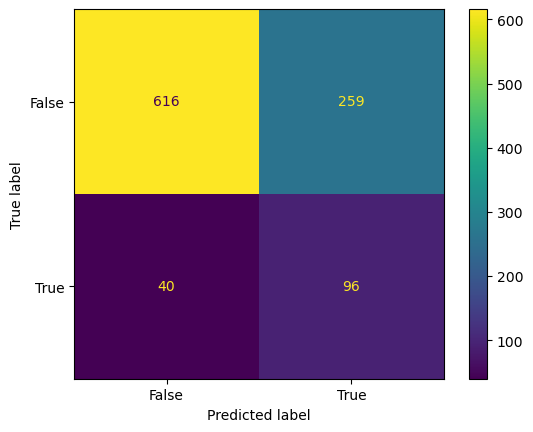

In [105]:
# confusio_matrix(y_val, y_probs)
confusion_matrix = metrics.confusion_matrix(prompt_df['label'].values, prompt_df['prompt_out'].values)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [109]:
# confusio_matrix(prompt_df['label'].values, prompt_df['prompt_out'].values)

In [107]:
precision, recall, f1_score = calculate_metrics(confusion_matrix)
print(precision, recall,f1_score )
print("Class\tPrecision\tRecall\tf1_score")
for i in range(len(precision)):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1_score[i]:.4f}")

[0.9390243902439024, 0.2704225352112676] [0.704, 0.7058823529411765] [0.8047028086218158, 0.39103869653767814]
Class	Precision	Recall	f1_score
0	0.9390		0.7040		0.8047
1	0.2704		0.7059		0.3910
